---

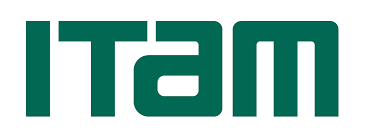

In [313]:
# Inicio de M para usuarios.
from IPython.core.display import Image, display
from tqdm import tqdm
display(Image('itam_logo.png', width=500, unconfined=True))

<font color='#508072'> 
$ \small \textbf {Data science and machine learning applied to financial markets} $  
$ \small  {Author: Daniel \space Omar \space Becerril \space Olguín} $  
$ \small {CU: 183605} $



---  
---

<font color='#508072'> 
$ \LARGE \textbf {Proyecto final:} $  
$ \large {BANXICO, \space politica \space monetaria} $

---

## Importa librerías

In [75]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sn


%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

## Input (Web Scrapping)

In [5]:
#URL 
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


In [6]:
#Inicio de Sesión 

with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [7]:
#Webb Scrapping sobre publicación
divpage = r.html.find("table[class='table table-striped bmtableview']", first=True)
papers_links = divpage.find("tr")

In [8]:
#Genera lista con elementos deseados
values = []
for link_secc in zip(papers_links):
    AbstractText = link_secc[0].find("td[class='bmtextview']", first=True).text
    referenceDate = link_secc[0].find("td[class='bmdateview']", first=True).text
    url_links = link_secc[0].absolute_links
    
    values.append([referenceDate, AbstractText, url_links])

In [9]:
#Genera DF
df_values = pd.DataFrame(values, columns=["date", "text", "url"])
df_values.head()

,date,text,url
0,13/02/20,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
1,19/12/19,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
2,14/11/19,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
3,26/09/19,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
4,15/08/19,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...


In [10]:
#Filtro para quitar fechas
Filtro_fecha = '2008-02-15'

df_values.date = pd.to_datetime(df_values.date)
df_values = df_values[df_values.date >= Filtro_fecha]

df_values.sort_values(by='date', ascending=True, inplace=True)
df_values.head()

,date,text,url
105,2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
104,2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
103,2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
102,2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...
101,2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...


In [11]:
df_values.reset_index(inplace=True)

In [12]:
#Guarda pickle
df_values.to_pickle("./comunicados-banxico.pkl")



## Genera Variable Objetivo

In [13]:
#Convierte la columna text en texto
df_values['text'] = df_values['text'].astype(str)
df_values.columns

Index(['index', 'date', 'text', 'url'], dtype='object')

In [14]:
#Prueba extracción de variable objetivo
df_values['text'][4]

'El objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) se incrementa en 25 puntos base\nTexto completo'

In [15]:
#Extracción de variable objetivo
df_values['category'] = df_values['text'].str.extract('(\W[a-z]\w{8,})')
df_values.category.fillna('mantiene', inplace = True)
df_values.head()

,index,date,text,url,category
0,105,2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...,mantiene
1,104,2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...,mantiene
2,103,2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...,mantiene
3,102,2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...,mantiene
4,101,2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,{https://www.banxico.org.mx/publicaciones-y-pr...,incrementa


### Estadísticos (Variable Obj)

In [71]:
#Distribución "category"
df_values['category'] = df_values['category'].astype(str)
df_values.groupby("category").count()


,index,date,text,url,Val_num,anio
category,,,,,,
disminuye,16,16,16,16,16,16
incrementa,18,18,18,18,18,18
mantiene,72,72,72,72,72,72


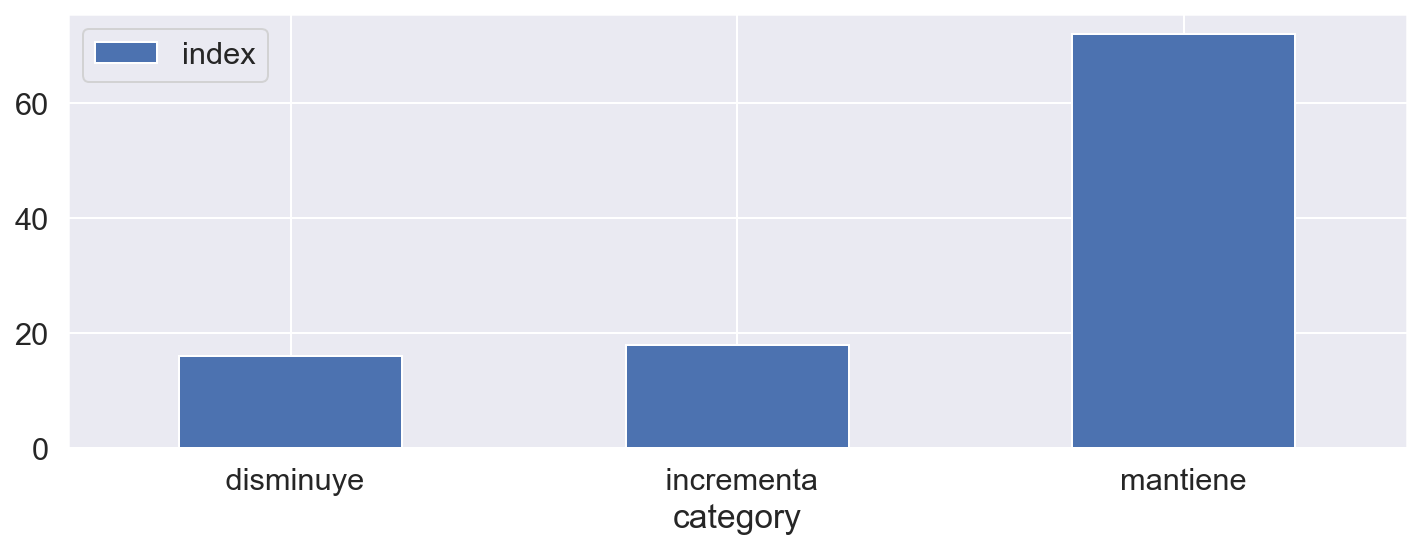

In [72]:
#Gráfico de barras
df_bar_plot = df_values.groupby("category").count()
ax = df_bar_plot.plot.bar(y='index', rot=0)

In [73]:
#Define variable para serie numérica
def f(row):
    if row['category'] == ' incrementa':
        val = 1
    elif row['category'] == 'mantiene':
        val = 0
    else:
        val = -1
    return val

df_values['Val_num'] = df_values.apply(f, axis=1)

In [74]:
#Redefine el index
df_values.index = df_values.date

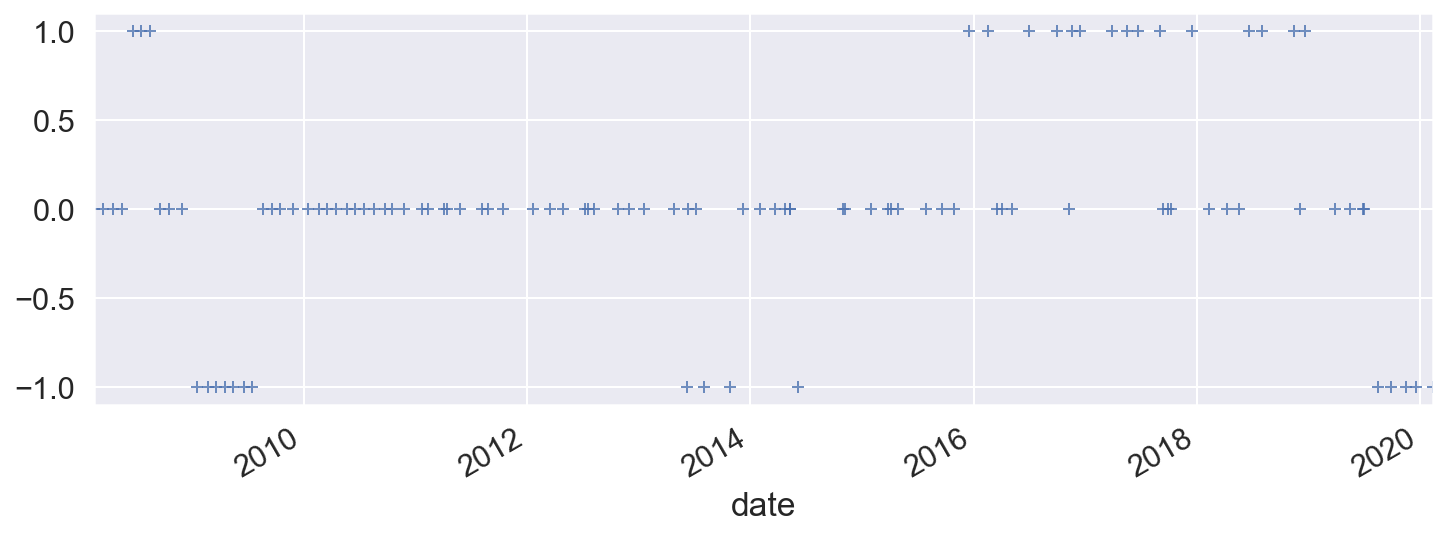

In [76]:
#Gráfico serie numérica 
df_values['Val_num'].plot(marker='+', alpha=0.8, linestyle='None')

### Variable Obj (Por año)

In [77]:
df_values['anio'] = df_values['date'].dt.year

In [78]:
df_values.groupby(['anio','category'])['Val_num'].count()

anio  category   
2008   incrementa     3
      mantiene        7
2009   disminuye      7
      mantiene        4
2010  mantiene       11
2011  mantiene        8
2012  mantiene        8
2013   disminuye      3
      mantiene        5
2014   disminuye      1
      mantiene        7
2015   incrementa     1
      mantiene        7
2016   incrementa     5
      mantiene        4
2017   incrementa     5
      mantiene        3
2018   incrementa     4
      mantiene        4
2019   disminuye      4
      mantiene        4
2020   disminuye      1
Name: Val_num, dtype: int64

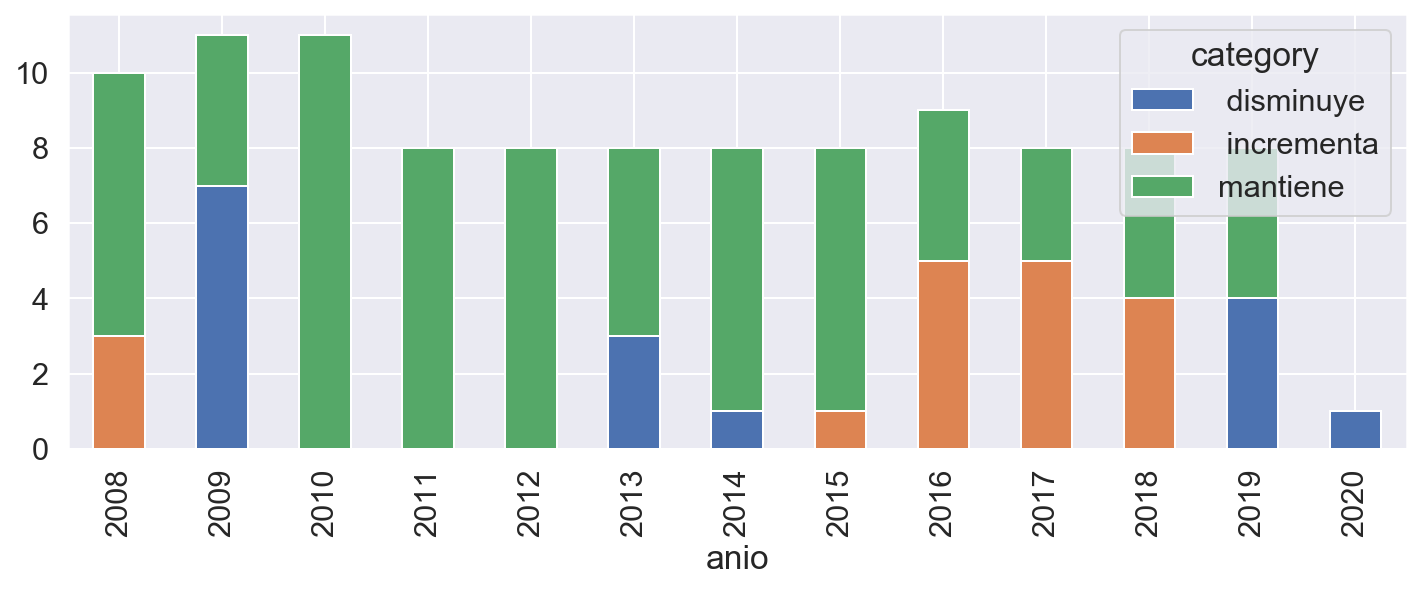

In [79]:
df2 = df_values.groupby(['anio', 'category'])['Val_num'].count().unstack('category').fillna(0)
df2.plot(kind='bar', stacked=True);

## Parte II

* Ocupando **únicamente** pandas, numpy; matplotlib; seaborn, con la información obtenida en la parte 1 (pandas DataFrame) modelar con Naïve Bayes si un documento dado pertence a la clase `mantiene`, `sube`, `baja`

**Pasos:**
1. Descargar PDFs
2. Limpiar los datos
3. Eliminar de todos los archivo las palabras que contengan `mantiene`, `sube`, `baja`.
4. Parte los documentos entre un set de entrenamiento (0.8) y uno de prueba (0.2)
5. Entrena el modelo con los documentos de entrenamiento y valida el resultado con una matriz de confusión usado la base de prueba

In [80]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PyPDF2 
import requests
import os

from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [29]:
for i in range(len(df_values)):
    print("La URL", list(df_values.url[i])[0])
    print("La fecha", df_values.index[i])
      
    filename = Path('descargas\BANXICO_estima_' + str(df_values.index[i].year) + '_' + str(df_values.index[i].month) + '_' + str(df_values.index[i].day) + '.pdf')
    
    url = list(df_values.url[i])[0]
    response = requests.get(url)
    filename.write_bytes(response.content)

La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{21A25F9E-4186-7A2E-3EEB-8D279E8D716F}.pdf
La fecha 2008-02-15 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{1AFBBDF2-F9BD-7972-B7EC-A106692521BA}.pdf
La fecha 2008-03-14 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{4E43A56F-E21C-DA8D-E793-1FB347044B17}.pdf
La fecha 2008-04-18 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{E4D0C362-251B-316B-68C8-C4893FD53FB3}.pdf
La fecha 2008-05-16 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{64384358-74A6-A9C2-425F-97C245F5BC2F}.pdf
La fecha 2008-06-20 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{ACF

La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{A15D84B0-1544-FF11-3DA1-3C2353BF89E6}.pdf
La fecha 2012-11-30 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{9FBF12AA-D7D8-E0B2-CCC4-5E6FB38FEBCE}.pdf
La fecha 2013-01-18 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{4C77F6F1-04BD-3D32-DE6B-DB6C32D93667}.pdf
La fecha 2013-04-26 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{27B95C51-9084-A3B9-EBE5-069CF8EC6AD4}.pdf
La fecha 2013-06-09 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{4E15E62F-8409-1715-2B50-29107081A593}.pdf
La fecha 2013-06-12 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{D05

La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{759F9C79-B40F-CD69-E10F-C56C3265923A}.pdf
La fecha 2018-11-15 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{A020627B-C6CC-C74D-02C8-42D99B9B6B29}.pdf
La fecha 2018-12-04 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{0CB97688-9500-D1A2-A000-C60DAF3E853F}.pdf
La fecha 2018-12-20 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{0F4AB746-781C-0D0A-5E3F-D5D28B14040C}.pdf
La fecha 2019-03-28 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{F4FA44AB-E4ED-59FA-100A-7791AA0085CD}.pdf
La fecha 2019-05-16 00:00:00
La URL https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{BBE

In [81]:
def lee_pdf(n_index):
    pdfFileObj = open('descargas\BANXICO_estima_' + str(df_values.index[n_index].year) + '_' + str(df_values.index[n_index].month) + '_' + str(df_values.index[n_index].day) + '.pdf', 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    pageObj = pdfReader.getPage(0) 
    corpus = pageObj.extractText()
    corpus = corpus.replace('\n','')
    corpus = unidecode(corpus)
    work_tokenizer = RegexpTokenizer("[a-z]+")
    tokens = work_tokenizer.tokenize(corpus.lower())
    lista_stopwords = stopwords.words("spanish")
    lista_stopwords.append('mantener')
    lista_stopwords.append('incrementar')
    lista_stopwords.append('reducir')
    V1 = []
    for palabra in tokens:
        if palabra not in lista_stopwords:
            V1.append(palabra)
            
    return V1

In [33]:
lee_pdf(2)

['abril',
 'comunicado',
 'prensa',
 'anuncio',
 'politica',
 'monetaria',
 'junta',
 'gobierno',
 'banco',
 'mexico',
 'decidido',
 'ciento',
 'objetivo',
 'tasa',
 'interes',
 'interbancaria',
 'dia',
 'economia',
 'mundial',
 'continua',
 'debilitandose',
 'consenso',
 'analistas',
 'consiste',
 'probable',
 'economia',
 'unidos',
 'recesion',
 'intensidad',
 'duracion',
 'impacto',
 'economias',
 'dependera',
 'efectos',
 'crisis',
 'financiera',
 'proceso',
 'desendeudamiento',
 'diversos',
 'sectores',
 'economia',
 'real',
 'asimismo',
 'vislumbra',
 'periodo',
 'ajuste',
 'prolongado',
 'pais',
 'hogares',
 'reconstituyen',
 'ahorros',
 'debido',
 'perdida',
 'riqueza',
 'derivada',
 'caida',
 'precios',
 'viviendas',
 'banco',
 'reserva',
 'federal',
 'continuado',
 'reduciendo',
 'manera',
 'significativa',
 'tasa',
 'interes',
 'referencia',
 'tomado',
 'diversas',
 'medidas',
 'proveer',
 'liquidez',
 'mercados',
 'fin',
 'mitigar',
 'endurecimiento',
 'condiciones',
 'cred

## Modelo predictivo

### Test-train split

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
#Divide index de documentos 20 - 80 para el entrenamiento del modelo.
L1 = list(range(len(df_values)))

D1, D1_test = train_test_split(L1, test_size=0.2)

In [84]:
#Lista doc mantiene
lista_mantiene = []

#Lista doc mantiene
lista_incrementa = []

#Lista doc mantiene
lista_disminuye = []

for i in D1:
    if (df_values.category[i]) == ' incrementa':
        lista_incrementa.append(i)
    elif (df_values.category[i]) == 'mantiene':
        lista_mantiene.append(i)
    else :
        lista_disminuye.append(i)

print("Tamaño incrementa :",len(lista_incrementa))
print("Tamaño mantiene :",len(lista_mantiene))
print("Tamaño disminuye :",len(lista_disminuye))

Tamaño incrementa : 14
Tamaño mantiene : 59
Tamaño disminuye : 11


In [85]:

#Lista palabras INCREMENTA 
palabras_incrementa = []
for k in lista_incrementa:
    for item in (lee_pdf(k)):
        palabras_incrementa.append(item)
        
#Lista palabras MANTIENE 
palabras_mantiene = []
for k in lista_mantiene:
    for item in (lee_pdf(k)):
        palabras_mantiene.append(item)
        
#Lista palabras DISMINIYU 
palabras_disminuye = []
for k in lista_disminuye:
    for item in (lee_pdf(k)):
        palabras_disminuye.append(item)


In [86]:
N = len(palabras_incrementa) + len(palabras_mantiene) +len(palabras_disminuye)

N1 = len(palabras_incrementa)
N2 = len(palabras_mantiene)
N3 = len(palabras_disminuye)

print("Métrica incrementa", len(set(palabras_incrementa)) / len(palabras_incrementa))
print("Métrica mantiene", len(set(palabras_mantiene)) / len(palabras_mantiene))
print("Métrica disminuye", len(set(palabras_disminuye)) / len(palabras_disminuye))

print("---"*30)
print("Tamaño incrementa", N1)
print("Tamaño mantiene", N2)
print("Tamaño disminuye", N3)

Métrica incrementa 0.2638758231420508
Métrica mantiene 0.123601884971328
Métrica disminuye 0.3133289124668435
------------------------------------------------------------------------------------------
Tamaño incrementa 4252
Tamaño mantiene 17613
Tamaño disminuye 3016


In [87]:
pd.Series(palabras_incrementa).value_counts()


monetaria          59
economia           52
politica           52
inflacion          46
mexico             44
                   ..
diferentes          1
solida              1
idiosincrasicos     1
demandan            1
impacto             1
Length: 1122, dtype: int64

In [88]:
pd.Series(palabras_mantiene).value_counts()

inflacion      315
crecimiento    194
economia       181
monetaria      171
actividad      170
              ... 
agudizacion      1
reales           1
automotriz       1
tornandose       1
nominales        1
Length: 2177, dtype: int64

In [89]:
pd.Series(palabras_disminuye).value_counts()

inflacion       57
economica       38
actividad       34
mexico          34
economia        31
                ..
convergencia     1
acerca           1
previo           1
prima            1
inciden          1
Length: 945, dtype: int64

In [90]:
V = set(palabras_incrementa) | set(palabras_mantiene) | set(palabras_disminuye)
vocab = pd.DataFrame(index=V)

In [91]:
V1_c = pd.Series(palabras_incrementa, name="k1").value_counts()
V2_c = pd.Series(palabras_mantiene, name="k2").value_counts()
V3_c = pd.Series(palabras_disminuye, name="k3").value_counts()

In [92]:
# likelihood
L = (vocab.join(V1_c, how="left")
                .join(V2_c, how="left")
                .join(V3_c, how="left"))

L = L.fillna(0) + 1
L = L / L.sum(axis=0)
L.sample(10, random_state=314)

log_L = np.log(L)

log_L

,k1,k2,k3
impacto,-8.125779,-6.965130,-7.230744
dicho,-6.421031,-6.690693,-7.007601
sostenibilidad,-8.818926,-7.963659,-8.617039
empiezan,-8.818926,-9.216422,-8.617039
largos,-8.125779,-9.216422,-8.617039
...,...,...,...
desequilibrios,-8.818926,-9.216422,-8.617039
dependeran,-8.818926,-8.300131,-8.617039
encabezado,-8.818926,-9.216422,-8.617039
aceleraria,-8.125779,-9.909569,-8.617039


In [93]:
log_prior_k1 = np.log(N1 / N)
log_prior_k2 = np.log(N2 / N)
log_prior_k3 = np.log(N3 / N)

log_priors = np.array([log_prior_k1, log_prior_k2, log_prior_k3])
log_priors

array([-1.766715  , -0.34546719, -2.11017301])

### Test modelo

In [94]:
y_test = []
for i in D1_test:
    if (df_values.category[i]) == ' incrementa':
        y_test.append('incrementa')
    elif (df_values.category[i]) == 'mantiene':
        y_test.append('mantiene')
    else :
        y_test.append('disminuye')

In [95]:
y_test

['disminuye',
 'mantiene',
 'mantiene',
 'mantiene',
 'mantiene',
 'mantiene',
 'disminuye',
 'mantiene',
 'incrementa',
 'mantiene',
 'mantiene',
 'mantiene',
 'incrementa',
 'disminuye',
 'incrementa',
 'mantiene',
 'mantiene',
 'disminuye',
 'mantiene',
 'disminuye',
 'incrementa',
 'mantiene']

In [96]:

yhat_test = []

for j in D1_test:
    lista_doc = []
    for item in lee_pdf(j):
        if item in V:
            lista_doc.append(item)

    res = log_L.loc[lista_doc].sum(axis=0) + log_priors

    #Guarda Resultados
    if res.idxmax() == 'k1':
        yhat_test.append('incrementa')

    if res.idxmax() == 'k2':
        yhat_test.append('mantiene')

    if res.idxmax() == 'k3':
        yhat_test.append('disminuye')
        


In [98]:
confusion_matrix(y_test, yhat_test)

df_cm = confusion_matrix(y_test, yhat_test)
df_cm

array([[ 3,  0,  2],
       [ 0,  2,  2],
       [ 0,  1, 12]], dtype=int64)

***

***

<font color='#508072'> 
$ \LARGE \textbf {Final código} $  

***